# Introduction

This section covers data processing related to Cosmic Integration (see [Neijssel et al. 2020](https://arxiv.org/abs/1906.08136)). These notes merely show how to call the functions and how to construct the pipeline. It does not offer any derivations.

For these notes we assume that you have a sufficiently large COMPAS h5-data set with non-constant (preferably, randomly-sampled) metallicity and some number of double compact objects. If not, see Section 1 [Working With HDF5](./WorkingWithHDF5.ipynb), or download some data from our [Zenodo database](https://zenodo.org/communities/compas/?page=1&size=20), though note that some of the Zenodo data may be out of date (you may have to rename some parameter names to get this file to run).

The duration from the birth of the binary until the merger as a double compact object (DCO) can range from a few million years (lifetime of the stars) to more than 100 Gigayears depending on the evolution of the system.

This means two things

1. DCOs merge at different redshifts
2. Multiple DCOs merging at a specific redshift could have formed at different times.
    
We thus need to know the star formation that went into forming a single system. However, the star formation rate is non-constant over the lifetime of the universe. Furthermore, star formation is heavily dependent on the metallicity of the star forming gas, which also changes over the lifetime of the universe. Combined, we call this the metallicity-specific star formation rate (MSSFR).

The cosmic-intergation pipeline tries to predict the population of DCO mergers assuming a model for the MSSFR.
Here we show how to use the combination of scripts. We show the purpose of each separate script in the pipeline and how to combine them to derive our results. 

Note that although these pipelines are tailored for a COMPAS simulation, with some slight adjustments one could use these same pipelines for other (mock)-simulations provided all the information is given (see [Setting the Data](#1.-Setting-the-Data). 

If you make use of any these pipelines, we would appreciate if you cite the following papers:

Cosmic Integration https://arxiv.org/abs/1906.08136

Selection effects https://arxiv.org/pdf/1711.06287

## Material
        

### [1) Setting the Data ](#1.-Setting-the-Data)
Set the required columns and other information.

### [2) Setting the MSSFR ](#2.-Setting-the-MSSFR) 
Choose a model and plot it.

### [3) Setting the Selection Effects ](#3.-Setting-the-Selection-Effects)
Choose the sensitivity and calculate probability.

### [4) Rate at single redshift ](#4.-Rate-at-single-redshift)
Combine data, MSSFR, and selection effects.

### [5) Rate as function of redshift ](#5.-Rate-as-function-of-redshift)
Set the integral and combine results.

### [6) Fast Cosmic Integration ](#6.-Fast-Cosmic-Integration)
Do the whole routine in one go, using the phenomenological variation of the MSSFR and SFRD

## For the following sections, you will need to have the following python packages installed. 
## `numpy, h5py, pandas, matplotlib, astropy, scipy`

In [1]:
import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib import rc
import astropy.units as u
from   astropy.cosmology import WMAP9 as cosmology
from scipy import stats
from   scipy.optimize import newton
import warnings

# Import COMPAS root directory and set data
compasRootDir   = os.environ['COMPAS_ROOT_DIR'] 
imageDir        = compasRootDir + '/postProcessing/Tutorial/media/'
pathData        = 'COMPAS_CI_Output.h5'

# Import COMPAS specific scripts
sys.path.append(compasRootDir + '/postProcessing/PythonScripts/CosmicIntegration/')
import ClassCOMPAS, ClassMSSFR, ClassCosmicIntegrator 
import FastCosmicIntegration as FCI 
import selection_effects

# Magic function to set the backend of matplotlib to the 'inline' backend
%matplotlib inline

# 1. Setting the Data 

In order to calculate the formation rate of a type of double compact object at a given redshift, we need to know:

The grid of metallicities we assume for the integral

The amount of solar mass evolved per metallicity per system $\frac{d}{dMsun}(Z)$

The type of double compact object (DCO) we are interested in 

The metallicity  $Z$ at which each DCO formed and the delay time (time from formation till merger) $t_c$ for each DCO


Given a time at which it merges we can then calculate the time at which it formed to recover the MSSFR ($\frac{dMsun}{dt})$ 


In addition we need to know the component masses of the system in order to calculate any selection effects


The ClassCOMPAS.py is there to store the information that we need such that we can access it quickly when calculating the rates.

## Creating an instance of the COMPAS data class

To create an instance of the COMPAS output class, we need to specify the following attributes:

    path      = None
    
    lazyData  = True

    Mlower    = None
    Mupper    = None
    binaryFraction=None

Path: 
    
    path to the h5-data. 
    

lazyData:

    means we store additional info like the mass ratios, chirpmasses of 
    each DCO system. In principle this could be done externally but this
    is slightly easier when plotting/combingin info later on, 
    but it does use more memory
    
    
Mlower:

    lower limit used for M1 in the pythonSubmit of the simulation. 
    Needed to recover `true` amount of Msun evolved (see step 4)
    
Mupper:

    upper limit used for M1 in the pythonSubmit of the simulation. 
    Needed to recover `true` amount of Msun evolved (see step 4)

binaryFraction:


    assumed fraction of stars in binaries. 
    Needed to recover `true` amount of Msun evolved (see step 4)


In [2]:
# For now, assume all the defaults and just set the path
COMPASData = ClassCOMPAS.COMPASData(path=pathData)

ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid


The output are  reminders which will be explained in next steps

## 1.1 Total mass evolved

In the COMPAS simulation we often only evolve massive stars.
This means that the total mass in our simulation does not represent the total mass evolved
in all stars. Here we recover an estimate of what that total mass is using the
lower and upper mass for the primary from your python submit and assuming a binary fraction.

The code will then check your data and test per metallicity how much mass is evolved.
It assumes the metallicities are subject to the same pytonSubmit, but maybe due to sampling had a different number of systems. It also recovers from the data what metallicity grid is used

In [3]:
COMPASData.Mlower = 15
COMPASData.Mupper = 150
COMPASData.binaryFraction =0.7

COMPASData.setGridAndMassEvolved()

## 1.2 The grid of metallicities we assume for the integral

By default the ClassCOMPAS will automatically try to recover the metallicity grid from the data/
It assumes that metallicities of all the systems in the h5-data represent the assumed metallicity grid
for the calculation. 

        metallicities =Data['SystemParameters']['Metallicity@ZAMS_1'][()]
        self.metallicityGrid     = np.unique(metallicities)

In principle you could instead overwrite this with your own metallicity grid. However
remember to reassign the metallicities of each DCO and the amount of solar mass evolved per metallicity. However, we leave it at that for now. You can acces the grid by printing

In [4]:
print(COMPASData.metallicityGrid)

[0.00100046 0.00100047 0.00100055 ... 0.01997763 0.01998259 0.01999481]


## 1.3 The amount of solar mass evolved per system per Z

Again by default the ClassCOMPAS will automatically recover the amount of
`true`  amount of solar mass evolved per system using the totalMassEvolvedPerZ script and
by reading the total mass per system in the simulation. This recovers an amount of solar mass per metallicity of the metallicity grid (units Msun).

In [5]:
print(COMPASData.totalMassEvolvedPerZ)

[166.00585875 293.45495955  90.49922945 ... 282.98916491  78.68780696
  96.02288132]


## 1.4 The select type of DCO to calculate the merger rate for

To recover the metallicities delaytimes and other parameters of the DCOs you are interested in we use a boolean mask. The boolean mask, which has the same length as the DCO h5 group, selects the systems we want to include in the calculation. 

You could set your own mask using any combination you want by

    maskDCO = some criteria you like on the h5 data
    COMPASData.DCOmask = maskDCO
    
However, usually we are interested in a specific group of merging DCOs assuming a type of physics. The setCOMPASDCOmask()  allows you to quickly set the mask without doing the slicing yourself and takes the following arguments (default then all options)

    argument         = default   / options
    types            =  'BBH'    / 'BBH', 'BNS', 'BHNS', 'All' (BBH, BNS, or BHNS)
    withinHubbleTime =  True     / True, False 
    pessimistic      =  True     / True, False
    noRLOFafterCEE   =  True     / True, False

type: Type of double compact object (DCO) to mask for. Can also take the argument 'All' to mask for BBHs, BNSs, and BHNSs.

withinHubbleTime: If True, only use DCOs that merge within a Hubble time.

pessimistic: If True, mask out DCOs that have formed through a common-envelope event involving a Hertzsprung-gap donor. 

noRLOFafterCEE: If True, mask out DCOs that have at some point experienced RLOF immediately after a common-envelope event. 

In [6]:
COMPASData.setCOMPASDCOmask(types='BBH', pessimistic=True)

#Check if we have any system meeting the criteria
print('Number of DCO systems = ', np.sum(COMPASData.DCOmask))

Number of DCO systems =  22


## 1.5 - Get the metallicities and delay times

using the DCO mask defined in step 1.4 the class can now get the parameters of interest
for each merging DCO


In [7]:
COMPASData.setCOMPASData()

Now the data is set and you are ready to go

### For different Data

If you have your own simulation which is different then the COMPAS data, or you want
to test a toy model, then you can still use the set of pipelines for the cosmic integration.

The only thing you need to do is construct your own arrays.

Create an instance of the clasCOMPAS without a path

In [8]:
MockData = ClassCOMPAS.COMPASData()

Template COMPASData object created with no data path
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid


Then manually set each array for

    #grid for integral
    MockData.metallicityGrid
    MockData.totalMassEvolvedPerZ #same length array as grid
    
    #Metallicity of each system corresponding to a grid-point
    MockData.metallicitySystems
    MockData.delayTimes  #Myr
    MockData.mass1       #Msun
    MockData.mass2       #Msun    
    #All four arrays are same length since they correspond to number of systems

All other pipelines just read arrays and are independent of the data

So you could sample from the IMF for M1 and M2, 
create a grid in metallicities and uniformly sample from the grid and then sample
from a $t^{-1}$ delay time distribution, just note the assumed units :)

If you then set the totalMassEvolvedperZ to an array of ones, then you can at least create
predictions for the shape of the merger rate distributions. Since this array is only a normalization affecting the absolute rates.

# 2. Setting the MSSFR


The universe evolved over time and as such the star formation rate and the metallicity of the starforming gas change. The ClassMSSFR is a script which determines the amount of star formation that went into forming a system born at redshift z, in a metallicity bin dZ. In shorthand we will use the term metallicity-specific star formation, either indicated with MSSFR or SFRD(Z,z), which is a function of metallicity Z and redshift z. We will both use MSSFR and SFRD(Z,z) throughout this notebook and they are identical (just two different ways of naming the concept). 

A schematic picture of how the SFRD(Z,z) is constructed is given in Figure 10 of the COMPAS methods paper and added below. 

![SFRD_cartoon.png](SFRD_cartoon.png)

Typically, the SFRD(Z,z) (MSSFR) is created by combining a Star formation rate density (SFRD) with a metallicity distribution function dP/dZ. The latter is typically constructed by combining a galaxy stellar-mass function (GSMF) with a mass-metallicity relationship

For this script we assume that the SFR(z) and the metallicity distribution are independent of each other.
Hence the SFR is simply a normalization to the PDF of the metallicity distribution. Note that these distributions are averages over all galaxies at a specific redshift z and hence do not apply to specific galaxies.

The script allows for several combinations of distributions.
To this end we have to define the following steps


[2.1 Instantiate the MSSFR class](#2.1-Instantiate-the-MSSFR-class)

[2.2 Pick a SFR distribution ](#2.2-Pick-a-SFR-distribution)

[2.3 Pick a metallicity distribution ](#2.3-Pick-a-metallicity-distribution)

    Note that although this is meant to be used in the cosmic integration pipeline, this class can be independently used to plot distributions or as input for other calculations

[2.4 Examples of plotting ](#2.4-Examples-of-plotting)

    Figures 11, 13, and 14 from the COMPAS methods paper

## 2.1 Instantiate the MSSFR class

To create an instance we need to define the following parameters;

Here are the possible parameters and their default values

    verbose               = False,
    
    metallicityGrid       = None,
    
    binInLogSpace         = True,
    metallicityLowerLimit = 1E-90, 
    metallicityUpperLimit = 1.
                 
    logOH12sun            = 8.69,     
    solarMetallicity      = 0.0142, 
    cosmo                 = None

verbose:
    
    If to print messages of intermediate during the calculation
    
metallicityGrid:
    
    The grid assumed in order to create the metallicity bins dZ. By default set to None
    and in a pipeline it is automatically passed from the ClassCOMPAS file.
    
    
binInLogSpace:
    
    To create the bin edges you can either choose the midpoint between Z1 and Z2 or 
    alternatively you can choose the midpoint between log(Z1) and log(Z2). Since most distributions
    work in the logZ space it seemed more appropriate. The difference is not large. Else it hints
    of having too few gridpoints in metallicity since the curve changes a lot between Z1 and Z2.
    
metallicityLowerLimit:

    Since we integrate over dZ we need to define a lower limit 
    of the metallicity mass Fraction Z in our integral.
    We set it close to zero, but non-zero to avoid division by zero errors
    
metallicityUpperLimit:

    Since we integrate over dZ we need to define a upper limit 
    of the metallicity mass Fraction Z in our integral. 
    Since a fraction cannot go higher than 1 we set it to 1.
    
logOH12sun:

    The assumed solar oxygen abundance (Asplund)
    
solarMetallicity:

    The assumed solar metallicity mass fraction (Asplund)
    
cosmo:

    The assumed universe (omegaM, Omega Lambda etc) to translate between age/distance/time.
    If None it is set to WMAP9. In the cosmic integration pipeline the class is automatically is set by the
    ClassCosmicIntegrator.

In [9]:
#We use the defaults and for illustration purposes invent our own grid

#Absolute metallicities
metallicityGrid = np.logspace(-4, -1.5,100)

MSSFR = ClassMSSFR.MSSFR(metallicityGrid=metallicityGrid)

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts


## 2.2 Pick a SFR distribution

In [10]:
print(MSSFR.printSFRoptions())


        Default instance:
        self.SFRprescription       = None 

        pass string
        Current Options  = 'Madau et al. (2014)'
                           'Madau et al. (2017)'
                           'Strolger et al. (2004)'
                           'Neijssel et al. (2019)'
                           'Custom SFR'

        If you use Custom SFR also set the constants
        you want to use

        self.customSFR = [a,b,c,d] 
        
        which are used in a Madau et al like formula (see source code)

        
None


In [11]:
# Based on the options above lets pick the one of the paper

MSSFR.SFRprescription = 'Neijssel et al. (2019)'

## 2.3 Pick a metallicity distribution

The metallicity distribution comes in two types of flavours.

###  2.3.1 Mass metallicity and galaxy stellar mass function

The first combines a densitity distribution of galaxy stellar masses (GSMF) 
with a mass metallicity relation (MZ) relation in order to create a metallicity density function.
In our code instead we translate from metallicity to mass to solve the integral hence we use the inverse
ZM functions. The original MZ functions are still in the source code for plotting/testing purposes


If you want to use these variations then first set the metallicity prescription to 'MZ_GSMF'


In [12]:
MSSFR.Zprescription = 'MZ_GSMF'

Then pick your favourite GSMF and MZ relation
To look at the options. Please note that not all distributions are metallicity dependent
and some rely on fits to the results of the original paper and therefore can behave poorly when pushed to extremes such as at high redshifts for example Furlong et al.

In [13]:
MSSFR.printGSMFoptions()


        If you use MZ and GSMF relations
        i.e. self.Zprescription    = 'MZ_GSMF'

        Default instance
        self.GSMFprescription      = None
        Current Options = Panter et al. (2004) Single, 
                          Furlong et al. (2015) Single,
                          Furlong et al. (2015) Double
        


In [14]:
MSSFR.printZMoptions()


        If you use MZ and GSMF relations
        i.e. self.Zprescription    = 'MZ_GSMF'

        Default instance
        self.ZMprescription        = None
        Current Options = Ma et al. (2016),
                      Langer et al. (2006)
                      Langer et al. +offset (2006)
        


In [15]:
# Set to our old default model Barrett et al

MSSFR.GSMFprescription = 'Panter et al. (2004) Single'
MSSFR.ZMprescription   = 'Langer et al. (2006)'

### 2.3.2 redshift dependent log-normal distribution

Instead of a MZ-relation and GSMF you can use a redshift dependent log-normal distribution (see paper)
for more details. 

To use this method set the metallicity prescription to 'logNormal'

In [16]:
MSSFR.Zprescription = 'logNormal'

Note that although the code should ignore any chose GSMF/ZM relation when using this option (or vice-versa)
it is still nicer to set those to None just in case and for clarity :). 
    

In [17]:
#then pick your favourite option for the logNormal
MSSFR.printLogNormaloptions()


        If you use Log normal 
        i.e. self.Zprescription    = 'logNormal'

        Default instance
        self.logNormalPrescription      = None
        Current Options = 'Neijssel Phenomenological'
                          'Custom Phenomenological'

        If you use Custom Phenomenological remember to 
        additionally set 

        self.customLogNormal = [Z0, alpha, sigma]
        


In [18]:
MSSFR.logNormalPrescription ='Neijssel Phenomenological'

del MSSFR

## 2.4 Examples of plotting

The MSSFR class also has the function to return the fraction of SFR in a metallicity bin.

    MSSFR.returnMSSFR(self, metallicity=None, agesBirth=None, redshiftBirth=None)

The code is constructed such that it calculates the MSSFR for all systems coming from a specific metallicity given that you know their agesBirth or redshiftBirth (depending on the chosen MSSFR you need one or the other)

Note that if we define our own grid of metallicities and time at which we want to know the MSSFR 
then we can use this same function to visualise our assumed distribution.
Of course we can also directly calculate any subfunctions to plot them :)


lets start from scratch

In [19]:
metallicityGrid = np.logspace(-4, -1.5,100)

MSSFR = ClassMSSFR.MSSFR(metallicityGrid=metallicityGrid)
#SFR
MSSFR.SFRprescription = 'Neijssel et al. (2019)'

#metallicity
MSSFR.Zprescription = 'logNormal'
MSSFR.logNormalPrescription ='Neijssel Phenomenological'


ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts


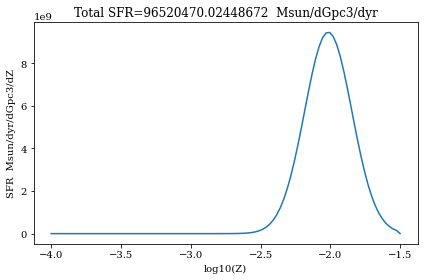

In [20]:
# What is our Z distribution at redshift 2

metallicityGrid = np.logspace(-4, -1.5,100)


SFRrate = np.zeros(len(metallicityGrid))

#our prescriptions do not need agesBirth only 
#redshift but require dummy value
redshift  = np.array([2])
agesBirth = redshift

for nrZ, Z in enumerate(metallicityGrid):
    SFRrate[nrZ] = MSSFR.returnMSSFR( metallicity=Z,\
                   agesBirth=agesBirth, redshiftBirth=redshift)
    
    
bins  = MSSFR.metallicityBinEdges
dZ    = np.diff(bins)

SFR_dZ = np.divide(SFRrate, dZ)
    
fig, axes = plt.subplots(1,1)

axes.plot(np.log10(metallicityGrid), SFR_dZ)
axes.set_title('Total SFR={}  Msun/dGpc3/dyr'.format(np.sum(SFRrate)))
axes.set_xlabel('log10(Z)')
axes.set_ylabel('SFR  Msun/dyr/dGpc3/dZ')
plt.tight_layout()

In [21]:
#Set latex environment for plots/labels
matplotlib.rc('font', **{'family': 'sans-serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']

/home/rwillcox/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  after removing the cwd from sys.path.


### 2.4.1 Plot the SFR options
in the following blocks we will plot the currently implemented star formation rate perscriptions (SFRs). The code and figure is based on Neijssel+2019, and this code will reproduce the figure in the COMPAS method paper. 

In [22]:
print(MSSFR.printSFRoptions())


        Default instance:
        self.SFRprescription       = None 

        pass string
        Current Options  = 'Madau et al. (2014)'
                           'Madau et al. (2017)'
                           'Strolger et al. (2004)'
                           'Neijssel et al. (2019)'
                           'Custom SFR'

        If you use Custom SFR also set the constants
        you want to use

        self.customSFR = [a,b,c,d] 
        
        which are used in a Madau et al like formula (see source code)

        
None


 we will now plot several of the available star formation rate density (SFRD) prescriptions that are available in COMPAS. This re-creates Figure 11 from the COMPAS methods paper (figure showing the SFRD as a function of redshift for the four default available options in COMPAS) 

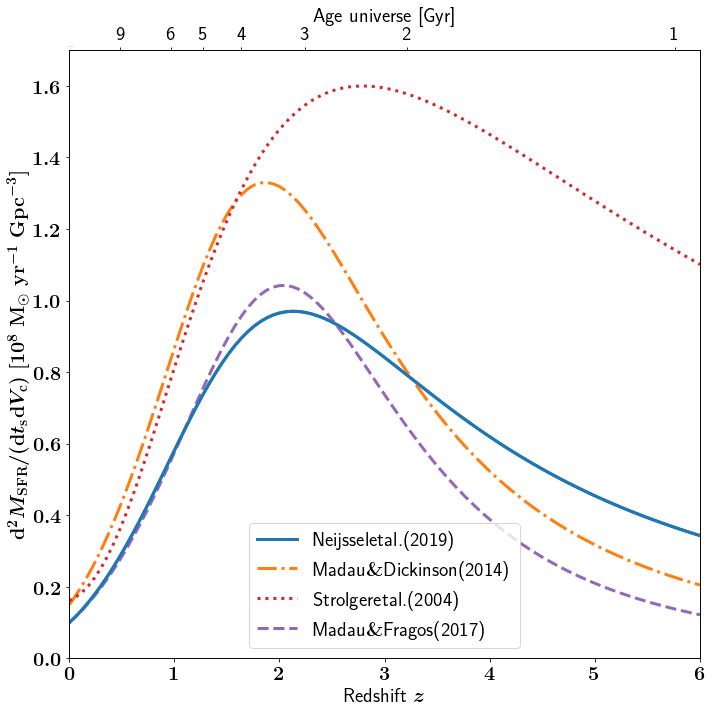

In [23]:
# fontsize
fs = 20

clist=['#1f77b4', '#ff7f0e', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#Plotting the SFR prescriptions
redshifts = np.linspace(0,6,100)
#strolger works in age not redshift
ages      = MSSFR.cosmology.age(redshifts).value

models = [ MSSFR.SFR_Neijssel(redshifts), MSSFR.SFR_Madau(redshifts),   
           MSSFR.SFR_Strolger(ages), MSSFR.SFR_Madau2(redshifts) ]
labels = [ r'Neijsseletal.(2019)', r'Madau$\&$Dickinson(2014)',
           r'Strolgeretal.(2004)', r'Madau$\&$Fragos(2017)']
ls     = [ '-', '-.', ':', '--']

fig, axes = plt.subplots(1,1, figsize=(10,10))
for ii, model in enumerate(models):
    axes.plot(redshifts, model,  c=clist[ii], lw=3., label=labels[ii], linestyle=ls[ii])
    #            axes.plot(redshifts,  c=clist[1], lw=3., label=      , linestyle=
    #                  axes.plot(redshifts,  c=clist[2], lw=3., label=, linestyle=
    #               axes.plot(redshifts,  c=clist[3], lw=3., label=   , linestyle=


axes2  = axes.twiny()
axes2.plot(redshifts, MSSFR.SFR_Neijssel(redshifts), c=clist[0], lw=3., label='Preferred model')


#find nearest redshift to age
agelabels = np.array([1,2,3,4,5,6, 9]) #Gyr
ageUniverse = MSSFR.cosmology.age(0)
redshiftTicks = np.zeros(len(agelabels))
for nr, age in enumerate(agelabels):
    distance = np.abs(ages-age)
    ind      = np.where(distance==np.min(distance))[0][0]
    redshiftTicks[nr] =  redshifts[ind]

axes2.set_xticks(redshiftTicks)
axes2.set_xticklabels(agelabels)

# axes layout
nameX = r'Redshift $z$'
nameY = r'$ {\rm{d}}^2M_{\rm{SFR}}/({\rm{d}}t_{{\rm{s}}}{\rm{d}}V_{\rm{c}}) \   [10^8\ {\rm{M}}_{\odot}\  {\rm{yr}}^{-1}\ {\rm{Gpc}}^{-3}]$'
axes.legend(loc=8, prop={'size':fs})
axes.yaxis.offsetText.set_fontsize(0.1)
axes.set_ylim(0, 1.7*10**8)
axes.set_xlabel(nameX, fontsize=fs)
axes.set_ylabel(nameY, fontsize=fs)
axes.tick_params(labelsize=fs)
axes.set_xlim(0,6)

# second x-axis for age
axes2.set_xlabel('Age universe [Gyr]', fontsize=fs)
axes2.tick_params(labelsize=fs)
axes2.set_xlim(0,6)

plt.tight_layout()
plt.savefig(imageDir + 'SFRplot.png', dpi=100)

### 2.4.2 Plotting the Galaxy stellar mass function GSMF 

the blocks below show how to plot and use the galaxy stellar mass functions as shown in Figure 13 of the COMPAS methods paper 

From Neijssel+2019:
Stellar mass density functions are given as schechter functions of the form:

$$ \phi(M) dM = \phi^{*} \left(\frac{M}{M_*}\right)^{\alpha} e^{\left(\frac{-M}{M_*}\right)} dM $$

$\phi^*$ = overall normalization

*M_*$ = determines turnover from power-law to exponential drop of

$\alpha $  = determines slope power low for  $M\leq M_*$

The prescription by Panter et al. 2004 is redshift independent and therefore
we just need to implement their notation. Alternatively we use a redshift dependent prescription by Furlong 
et al. They have both a single schechter function in the same form as above, as well as a double schechter function of the form

$$ \phi(M) dM = \left[ \phi_1 \left(t\right)^{\alpha_1} + 
                       \phi_2 \left(t\right)^{\alpha_2} \right] * e^{-\frac{M}{M_c}} $$
                       
However they only show the constants and several redshifts. Hence most of this notebook is dedicated
to turning this into a parametrized form to be used at any redshift. 

### 2.4.3 Plotting the tabulated Furlong prescription
The plots in the paper such as Furlong et al do NOT plot M vs phi dM
instead they plot logM vs phi dlogM

so we need to transform the equation a bit


$$ y = log_{10}(x) $$
$$ \frac{dy}{dx} = \frac{1}{x} $$
$$ dx = x dy$$

since x = M/M* we have a +1 in the alpha term for the schechter dlog10 function

In [24]:
def singleSchechterPerLog10(logM, logMc,  phi,  alpha):
    M  = 10**logM
    Mc = 10**logMc
    x  = M/Mc
    schechter = phi * ((x)**(alpha+1)) * np.exp(-x)
    return schechter


def doubleSchechterPerLog10(logM, logMc,  phi1,  a1, phi2, a2):
    M  = 10**logM
    Mc = 10**logMc
    x  = M/Mc
    schechter =(phi1 * ((x)**(a1+1))+  phi2 * ((x)**(a2+1))) * np.exp(-x)
    return schechter


def doubleSchechterPerLog10FurlongPolynomial(logM, z, power):
    logMc, phi1, a1, phi2, a2 = polynomialFitDoubleSchechter(z, power)
    schechter = ((phi1*(10**((a1+1)*(logM-logMc)))) + (phi2*(10**((a2+1)*(logM-logMc)))))\
               *(np.exp(-pow(10,logM-logMc)))
    return schechter


def doubleSchechterPerLog10FurlongLineair(logM, z):
    logMc, phi1, a1, phi2, a2, ratio = lineairFitDoubleSchechter(z)
    schechter = ((phi1*(10**((a1+1)*(logM-logMc)))) + (phi2*(10**((a2+1)*(logM-logMc)))))\
               *(np.exp(-pow(10,logM-logMc)))
    return schechter


def singleSchechterPerLog10FurlongPolynomial(logM, z, power):
    logMc, phi, alpha = polynomialFitSingleSchechter(z, power)
    schechter = phi*(10**((alpha+1)*(logM-logMc)))*(np.exp(-pow(10,logM-logMc)))
    return schechter


def singleSchechterPerLog10FurlongLineair(logM, z):
    logMc, phi, alpha = lineairFitSingleSchechter(z)
    schechter = phi*(10**((alpha+1)*(logM-logMc)))*(np.exp(-pow(10,logM-logMc)))
    return schechter

In [25]:
#In Furlong et al they note that a double schechter function
#fits the data better at the high galaxy stellar masses (log10M > 11)
def lineairFitSingleSchechter(z):

    try:
        nr = len(z)
    except:
        z  = np.array([z])
        nr = 1
        
    fitlogMc        = np.array([11.14, 11.11, 11.06, 10.91, 10.78, 10.60])
    fitphi1          = np.array([0.84, 0.84, 0.74, 0.45, 0.22, 0.12])*10**(-3)
    fita1            = np.array([-1.43, -1.45, -1.48, -1.57, -1.66, -1.74])

    
    fitredshifts = np.array([0.1, 0.5, 1.0, 2.0, 3.0, 4.0])
    
    fitvalues = [fitlogMc, fitphi1, fita1]
    thresholds = [0.0, 0.5, 1.0, 2.0, 3.0, 10000000]
    r          = []
    for nrv, values in enumerate(fitvalues):
        dz     = np.diff(fitredshifts)
        dydz   = np.divide(np.diff(values), dz)
        yvalues= np.zeros(nr)
        for nrz, redshift in enumerate(thresholds[:-1]):
            mask = (z>= thresholds[nrz]) & (z<=thresholds[nrz+1])
            if nrz == 0 :
                #interpolate from z0.5 down
                dz   = 0.5 - z[mask]
                interpolatedValue  = values[nrz+1] - np.multiply(dz, dydz[nrz])
            else:
                #interpolate up
                dz   = z[mask] - redshift
                interpolatedValue  = values[nrz] + np.multiply(dz, dydz[nrz])
            yvalues[mask] =  interpolatedValue
        r.append(yvalues)
        
    r[1][r[1] <0] = 0  #phi1
    return r[0], r[1], r[2]

def lineairFitDoubleSchechter(z):

    try:
        nr = len(z)
    except:
        z  = np.array([z])
        nr = 1

    
    fitredshifts = np.array([0.1, 0.5, 1.0, 2.0, 3.0, 4.0])
    fitlogMc     = np.array([10.95, 10.88, 10.74, 10.44, 10.19, 10.00])
    fitphi1      = np.array([1.45, 1.61, 1.51, 1.06, 0.63, 0.24])*10**-3
    fita1        = np.array([-1.31, -1.24, -0.98, -0.25, 0.23, 0.43])
    fitphi2      = np.array([0.0,  0.08,   0.48, 0.8, 0.61, 0.43])*10**-3
    fita2        = np.array([-2.22, -1.79, -1.62, -1.58, -1.64, -1.69])
    
    ratioPhi1Phi2 = np.divide(fitphi2, fitphi1) #Do it in this order because phi2 is zero
    
    fitvalues  = [fitlogMc, fitphi1, fita1, fitphi2, fita2, ratioPhi1Phi2]
    thresholds = [0.0, 0.5, 1.0, 2.0, 3.0, 10000000]
    r          = []
    for nrv, values in enumerate(fitvalues):
        dz     = np.diff(fitredshifts)
        dydz   = np.divide(np.diff(values), dz)
        yvalues= np.zeros(nr)
        for nrz, redshift in enumerate(thresholds[:-1]):
            mask = (z>= thresholds[nrz]) & (z<=thresholds[nrz+1])
            if nrz == 0 :
                #interpolate from z0.5 down
                dz   = 0.5 - z[mask]
                interpolatedValue  = values[nrz+1] - np.multiply(dz, dydz[nrz])
            else:
                #interpolate up
                dz   = z[mask] - redshift
                interpolatedValue  = values[nrz] + np.multiply(dz, dydz[nrz])
            yvalues[mask] =  interpolatedValue
        r.append(yvalues)
        
    r[3][r[3]<0]  = 0  #phi2
    r[1][r[1] <0] = 0  #phi1
    r[4][r[4]<-2] = -2 #a2
    return r[0], r[1], r[2], r[3], r[4], r[5]

def polynomialFitSingleSchechter(z, power):
    try:
        nr = len(z)
    except:
        z  = np.array([z])
        nr = 1

    fitredshifts = np.array([0.1, 0.5, 1.0,2.0, 3.0, 4.0])
    fitlogMc     = np.array([11.14, 11.11, 11.06, 10.91, 10.78, 10.60])
    fitphi       = np.array([0.84, 0.84, 0.74, 0.45, 0.22, 0.12])*10**(-3)
    fita         = np.array([-1.43, -1.45, -1.48, -1.57, -1.66, -1.74])
        
    fitvalues    = [fitlogMc, fitphi, fita]
    y            = []
    
    for nrv, values in enumerate(fitvalues):
        ysub         = np.zeros(nr)
        coefficients = np.polyfit(fitredshifts,values, power)[::-1]
        for nrpower, coefficient in enumerate(coefficients):
            ysub     = np.add(ysub, coefficient*np.power(z,nrpower))
        y.append(ysub) 
        
    return y[0], y[1], y[2]

def polynomialFitDoubleSchechter(z, power=5):
    try:
        nr = len(z)
    except:
        z  = np.array([z])
        nr = 1    
        #Constants for double schechter fit
    fitredshifts = np.array([0.1, 0.5, 1.0, 2.0, 3.0, 4.0])
    fitlogMc2    = np.array([10.95, 10.88, 10.74, 10.44, 10.19, 10.00])
    fitphi1      = np.array([1.45, 1.61, 1.51, 1.06, 0.63, 0.24])*10**-3
    fita1        = np.array([-1.31, -1.24, -0.98, -0.25, 0.23, 0.43])
    fitphi2      = np.array([0.0, 0.08, 0.48, 0.8, 0.61, 0.43])*10**-3
    fita2        = np.array([-2.22, -1.79, -1.62, -1.58, -1.64, -1.69])
    
    fitvalues    = [fitlogMc2, fitphi1, fita1, fitphi2, fita2]
    y            = []
    
    for nrv, values in enumerate(fitvalues):
        ysub         = np.zeros(nr)
        coefficients = np.polyfit(fitredshifts,values, power)[::-1]
        for nrpower, coefficient in enumerate(coefficients):
            ysub     = np.add(ysub, coefficient*np.power(z,nrpower))
        y.append(ysub)       
        
    return y[0], y[1], y[2], y[3], y[4]

### 2.4.4 The constants from the papers

In [26]:
#GSMF from panter et al 2004
#https://academic.oup.com/mnras/article/355/3/764/952806
#Used in Norman & Langer  2006
#http://iopscience.iop.org/article/10.1086/500363/meta
#Note that this is redshift independent!
logMc = np.log10(7.64*(10**10))
phi   = 7.8* (10**(-3)) 
alpha = -1.16


#From Furlong et al https://academic.oup.com/mnras/article-abstract/450/4/4486/1747992
#logMc defines the turnover between power law and exponential drop
#Reproducing figure A1

fitRedshifts   = np.array([0.1, 0.5, 1.0,2.0, 3.0, 4.0])

#fit values single schechter
logMc_s        = np.array([11.14, 11.11, 11.06, 10.91, 10.78, 10.60])
phi_s          = np.array([0.84, 0.84, 0.74, 0.45, 0.22, 0.12])*10**(-3)
a_s            = np.array([-1.43, -1.45, -1.48, -1.57, -1.66, -1.74])

#fit values double schechter
logMc_d     = np.array([10.95, 10.88, 10.74, 10.44, 10.19, 10.00])
phi1_d      = np.array([1.45, 1.61, 1.51, 1.06, 0.63, 0.24])*10**-3
a1_d        = np.array([-1.31, -1.24, -0.98, -0.25, 0.23, 0.43])
phi2_d      = np.array([0.0,  0.08,   0.48, 0.8, 0.61, 0.43])*10**-3
a2_d        = np.array([-2.22, -1.79, -1.62, -1.58, -1.64, -1.69])

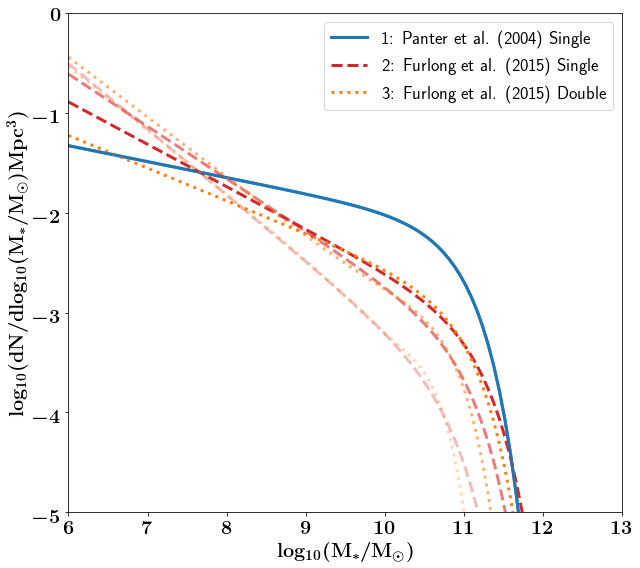

In [27]:
logM      = np.linspace(6,13,100)
redshifts = [0., 1.5, 3.]
#color per prescription
mycolors = clist
#linestyle per redshift
linestyles= ['-', '--', ':']
alphas = [1,0.6,0.3]


fig, axes = plt.subplots(1,1, figsize=(9,8))

for nrz, z in enumerate(redshifts):
    if nrz == 0:
        label1, label2, label3 = '1: Panter et al. (2004) Single',\
        '2: Furlong et al. (2015) Single','3: Furlong et al. (2015) Double'
    else:
        label1, label2, label3 = None, None, None
    Norman   = singleSchechterPerLog10(logM, logMc,  phi,  alpha)
    axes.plot(logM, np.log10(Norman), c=mycolors[0], label=label1, lw=3,  linestyle=linestyles[0], alpha=alphas[nrz])
    Furlongsingle = singleSchechterPerLog10FurlongLineair(logM, z)
    axes.plot(logM, np.log10(Furlongsingle), c=mycolors[2], label=label2, lw=3,  linestyle=linestyles[1], alpha=alphas[nrz])
    FurlongDouble = doubleSchechterPerLog10FurlongLineair(logM, z)
    axes.plot(logM, np.log10(FurlongDouble), c=mycolors[1], label=label3, lw=3, linestyle=linestyles[2], alpha=alphas[nrz])

nameX = r'$\rm log_{10}(M_{*}/M_{\odot})$'
nameY = r'$\rm log_{10}( dN / dlog_{10}(M_*/M_{\odot})Mpc^{3})$'

axes.set_ylim(bottom=-5, top=0)
axes.set_xlim(left=6, right=13)
axes.legend(prop={'size': 18})
axes.set_xlabel(nameX, fontsize=fs)
axes.set_ylabel(nameY, fontsize=fs)
axes.tick_params(labelsize=fs)

plt.tight_layout()
plt.savefig(imageDir + 'GSMFplot.png')

### 2.4.5 Plotting the MZR relations 

blocks below show how to use and plot the mass-metallicity relations as shown in Figure 14 of the COMPAS methods paper.

From Neijssel+2019: we get the relationship between the galaxy stellar mass and the oxygen to hydrogen 
number density. Using the relation between number density and mass fractino above we translate this to a metallicity.
This metallicity is that of the interstellar gas. We assume that the stars that form at redshift z have the same metallicity as that of the interstellar gas


Below we plot the different MZ relations from the MSSFR class as found in the respective papers.
Given that in the project we want to use the inverse (ZM-relations) we test these too.

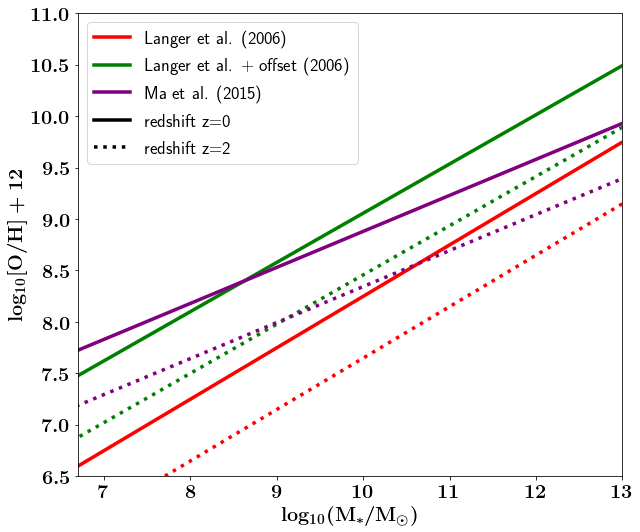

In [28]:
fig, axes = plt.subplots(1,1, figsize=(9,7.5))

MZlabels    = ['Langer et al. (2006)', 
               'Langer et al. + offset (2006)', 
               'Ma et al. (2015)']
MZfunctions = [MSSFR.Langer2005MZ,  None, MSSFR.Ma2015MZ]
ZMfunctions = [MSSFR.Langer2005ZM,  MSSFR.Langer2005OffsetZM, MSSFR.Ma2015ZM]

MSSFR.logOH12sun            = 8.69    #fraction number density solar
MSSFR.solarMetallicity      = 0.0142  #fraction mass in metals solar, based on Asplund
logOH12sun  = 8.69
logZZsun  = np.linspace(-3, 3, 100)

colors     = ['red','green','purple'] 
linestyles  = ['-', ':'] 
fs=20
lw=3.5

for ii, label in enumerate(MZlabels):
    
    z=0
    #translate back to LogM using inverse
    logM      = ZMfunctions[ii](10**logZZsun, z)
    #I want to plot logOH12 not ZZsun
    logOH12   =  MSSFR.LogOH12vsLogZZsun(logZZsun, inValue='logZZsun')
    #to prevent overlapping dashed lines
    axes.plot(logM, logOH12, c=colors[ii], label=label,\
              linestyle=linestyles[0], lw=lw)

    z=2
    logM      = ZMfunctions[ii](10**logZZsun, z)
    #I want to plot logOH12 not ZZsun
    logOH12   =  MSSFR.LogOH12vsLogZZsun(logZZsun, inValue='logZZsun')
    #to prevent overlapping dashed lines
    axes.plot(logM, logOH12, c=colors[ii],\
              linestyle=linestyles[1], lw=lw, alpha=1)    

# Add custom legend lines for linestyle
handles, labels = axes.get_legend_handles_labels()
handles.extend([mpl.lines.Line2D([0], [0], color='k', label='redshift z=0', linestyle=linestyles[0], lw=lw),
                mpl.lines.Line2D([0], [0], color='k', label='redshift z=2', linestyle=linestyles[1], lw=lw)
               ])
axes.legend(handles=handles, loc=2, prop={'size':18})

axes.set_ylim(6.5, 11)
axes.set_xlim(6.7,13)

nameX = r'$\rm log_{10}(M_{*}/M_{\odot})$'
nameY = r'$\rm log_{10}[O/H]+12$'
axes.set_xlabel(nameX, fontsize=fs)
axes.set_ylabel(nameY, fontsize=fs)
axes.tick_params(labelsize=fs)


plt.tight_layout()
plt.savefig(imageDir + 'MZrelations.png')

# 3. Setting the Selection Effects


The selection effects assign a probability of observing a system.

We determine if we can confidently select a system by choosing a signal-to-noise ratio (SNR), for which we often use 8. 

The SNR depends on the individual component masses, the distance and the orientation of the binary compared to the gravitational wave detector.  

By sampling uniformly over the possible orientations of the system
we can assign the fraction of the time the system at that distance can be observed. This fraction is the probability.


The SNR also depends on the sensitivity of the detector

combined we need to pass to the function

detection_probability(m1, m2, redshift, distance, snr_threshold,sensitivity='design')

If you use this pipeline we would appreciate it if you cite
Selection effects   ; https://arxiv.org/pdf/1711.06287


## Quick example

In [29]:
m1 = 40 #Msun
m2 = 40 #Msun
redshift = 0.1
distance = 463.4  # Mpc quick estimate for illustration purpuses
                  # code uses astropy toconvert
                  # redshift to luminosity distance
snr_threshold = 8
sensitivity = 'O1'

P = selection_effects.detection_probability(m1, m2, redshift, distance, snr_threshold,sensitivity=sensitivity)
print(P)

0.776353


# 4. Rate at single redshift

Here we show how to calculate the merger rate density of systems
merging at a single redshift z. By now we assume you understand the indiviual pipelines of;

ClassCOMPAS:

    -- (handling the (mock) data needed)
    
ClassMSSFR:

    -- defining the model for metallicity specific SFR
    
selection_effects:

    -- module to calculate probility detecting a system



Here we show which additional steps are needed for the calculation.
All these steps are done by default in the ClassCosmicIntegrator.
We highlight the steps here outside the function for clarity
since the ClassCosmicIntegrator merely acts as a giant for loop over multiple redshifts and a way to conveniently store the results

## 4.1 Set up data and MSSFR model

In [30]:
# Create instance COMPAS data class

COMPAS = ClassCOMPAS.COMPASData(path=pathData)

ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid


In [31]:
#Set the type of DCO of interest and recover their parameters
COMPAS.Mlower = 15
COMPAS.Mupper = 150
COMPAS.binaryFraction =0.7

COMPAS.setGridAndMassEvolved()

COMPAS.setCOMPASDCOmask() #Pessimistic BBHs
COMPAS.setCOMPASData()

In [32]:
# The MSSFR model

#use the metallicityGrid of the Data
metallicityGrid = COMPAS.metallicityGrid

#Create instance Class
MSSFR = ClassMSSFR.MSSFR(metallicityGrid=metallicityGrid)


ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts


In [33]:
#Set the MSSFR model
MSSFR.SFRprescription = 'Neijssel et al. (2019)'
MSSFR.Zprescription = 'logNormal'
MSSFR.logNormalPrescription ='Neijssel Phenomenological'

## 4.2 Define the redshifts

The entire calculation depends on defining a redshift
at which the DCOs merge. Then using the delaytimes and astropy
you need to recover when the systems were born

First define our cosmology

In [35]:
mergerRedshift = 0.2

#Define an age when the first stars formed based on redshift
firstSFR = cosmology.age(10).value
#single value in units of Gyr
ageUniverseAtMergerGyr = cosmology.age(mergerRedshift)
#Recover the array delaytimes in Units of Gyr
delayTimeGyr = np.divide(COMPAS.delayTimes, 1000)
#Calculate the age at which they were born
ageBirth   = ageUniverseAtMergerGyr.value - delayTimeGyr
#If they are born before first SFR mask them
maskUnreal = ageBirth<firstSFR
#I set those to minus 1 to label them
#This way we can use this as a mask everywhere instead of having
#to slice the data in different ways. Useful for larger calculations
ageBirth[maskUnreal] = -1


Note that the above might further reduce the number of DCOs in the data, despite we use the flag merger in a Hubble time. This because that flag assumes redshift is zero. When we change our reference frame to higher redshifts, then the universe is younger and therefore fewer systems will be able to merge in  time

We set the unphysical systems to -1. This because later when we loop over redshifts the number of possible systems can vary. However I want to fill in the rates in a predefined 2D array of fixed shape (nr systems, nr of redshift bins). Hence I assume the largest array (size of nr of DCOs) and set the rate to zero in case.  Note that the MSSFR script also depends on the mask of systems being unreal of -1. (see returnMSSFR())

To recover the redshift it is a bit tricky. Astropy can quicly
calculate the age from redshift, but the inverse is more difficult.
In the code we use look up the nearest value in a dense precalculated table.
Here we use a older method to calculate (for credits see source code classCosmicintegrator) which is considerably slower. 

In [36]:
redshiftsBirth = np.zeros(len(ageBirth))
for nr, age in enumerate(ageBirth):
    if age != -1:
        redshiftsBirth[nr] = newton(lambda x: cosmology.age(x).value-age, 0)
        
    else:
        redshiftsBirth[nr] = -1

nDCOs = len(COMPAS.delayTimes)
nMerg = np.sum(ageBirth!=-1)
print("Number of DCOs: {}\nNumber of merging DCOs: {}".format(nDCOs, nMerg))

Number of DCOs: 264
Number of merging DCOs: 257


## 4.3 Calculate the rate of systems per metallicity

The code is structured to do the calculation per subpopulation of DCOs of a single metallicity. Note that if the system was not physically possible (age == -1) then the rate is set to zero.

In [37]:
#create an array for rate per system merging at redshift z
ratePerSystem = np.zeros(len(COMPAS.delayTimes))

In [38]:
for nrZ, Z in enumerate(metallicityGrid):
    maskZ    = COMPAS.metallicitySystems == Z
    #give MSSFR per system which has metallicity Z [Msun/dGpc3/dyr]
    mssfr    = MSSFR.returnMSSFR(metallicity=Z,\
                                 agesBirth  =ageBirth[maskZ],
                                 redshiftBirth=redshiftsBirth[maskZ])
    #Calculate rate using amount of Msun evolved [dN/dGpc3/dyr]
    RatesZ   = np.divide(mssfr, COMPAS.totalMassEvolvedPerZ[nrZ])
    #Fill the rates in the defined array according to mask
    ratePerSystem[maskZ] = RatesZ

In [39]:
print(metallicityGrid)

[0.00100002 0.00100003 0.00100003 ... 0.01999811 0.01999971 0.0199998 ]


In [40]:
print(ratePerSystem)

[2.33648923e-08 8.62518916e-04 1.86628965e-12 2.25100389e-01
 0.00000000e+00 0.00000000e+00 1.33129807e-08 3.85439321e-05
 1.73513124e-02 0.00000000e+00 2.46871676e-01 2.56007936e-12
 0.00000000e+00 2.88135949e-05 0.00000000e+00 1.47503317e-12
 2.90734257e-09 0.00000000e+00 0.00000000e+00 1.45638225e-12
 1.85748915e-04 2.62123820e-08 1.77872781e-07 1.83891650e-09
 0.00000000e+00 0.00000000e+00 6.99373157e-11 6.53354658e-08
 8.54723708e-07 2.51886805e-12 1.48138042e-06 1.22486907e-07
 2.45177642e-04 1.59994847e-03 0.00000000e+00 2.82507870e-06
 2.38605571e-08 9.46598235e-03 3.23315261e-07 2.64845332e-02
 2.76666924e-09 1.46428905e-01 2.26400767e-07 0.00000000e+00
 0.00000000e+00 1.45494212e-01 3.34470055e-06 5.94054093e-01
 1.05305483e-08 0.00000000e+00 5.80569608e-05 1.12673962e-10
 5.34615124e-10 5.75352888e-02 3.18115520e-11 0.00000000e+00
 1.62977487e-12 2.11031759e-01 0.00000000e+00 4.39511446e-08
 1.09192115e-04 1.00074524e-05 1.38438310e-09 0.00000000e+00
 6.59039256e-02 2.392283

In [41]:
print(np.sum(ratePerSystem))

13.594027923751622


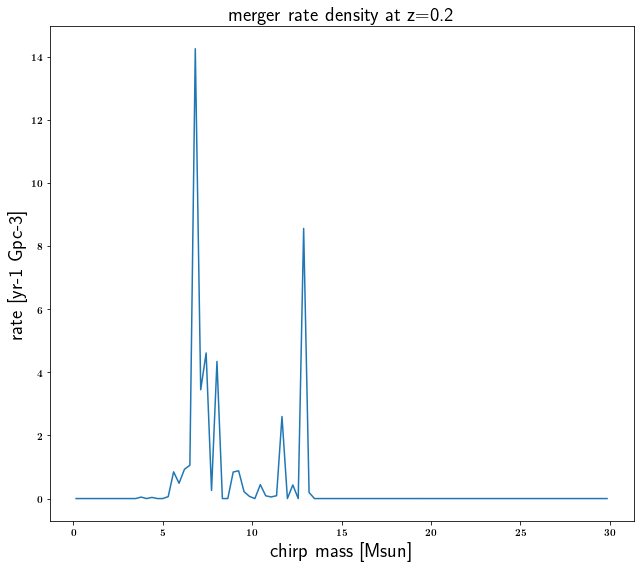

In [42]:
# Using the rates in a histogram

chirpMasses = COMPAS.mChirp

binsM = np.linspace(0,30,100)
dM    = np.diff(binsM)
center= (binsM[1:]+binsM[:-1])/2.

#remember that the reight is essentially a weight per system

y , _     = np.histogram(chirpMasses, bins=binsM, \
                     weights=ratePerSystem)

dydMchirp = np.divide(y, dM)

fig, axes = plt.subplots(1,1, figsize=(9,8))
axes.plot(center, dydMchirp)
axes.set_xlabel('chirp mass [Msun]', fontsize=20)
axes.set_ylabel('rate [yr-1 Gpc-3]', fontsize=20)
axes.set_title('merger rate density at z={}'.format(mergerRedshift), fontsize=20)
plt.tight_layout()

Now here we only have the chirp mass distribution at a single redshift
per unit volume. The next step is to do it over a range of redshifts
and get the absolute rates.

# 5. Rate as function of redshift


Here we present show how to calculate the merger rate densities and observed probabilities
for a population of double compact object mergers using the ClassCosmicIntegrator

In reality this class is one major for loop to redo the calculation at a single redshift for different redshifts and a range of metallicities (see earlier notes).

It combines all the classes/modules that we presented in the cosmic integration notes
In addition it stores the results into several 2D arrays for easy plotting/binning
already taking into account selection effects and volumes of the different redshift shells.

Here we show:

- How to set up the entire pipeline. The code specifically raises warnings/statements
    to help to remind you. This is simply a summary of the previous notes in the Cosmic Integration section.


- How to calculate the rate and plot the results using the 2D arrays in the ClassCosmicIntegrator

- How to loop over variations efficiently to create different distributions

## 5.1 Instance of Cosmic integrator class

The main thing that needs to be defined in this class is the universe and the
number of shells for which we want to calculate the merger rate densities. In addition we also set the GW-detector here

To this end, the following variables need to be defined in the instance (showing their default values)

    #For Data
    pathCOMPAS         = None
    
    #Defining Universe
    Cosmology          = 'WMAP'
    hubbleConstant     = 67.8
    omegaMatter        = 0.308
    redshiftFirstSFR   = 10.
    
    #Defining integral
    minRedshift        = 0.0
    maxRedshift        = 2.
    nrRedshiftBins     = 20
    
    #Method for calculating redshift from age
    RedshiftTabulated  = True
    RedshiftTabulatedResolution = 100000
    
    #Detector
    GWdetector_sensitivity      = 'O1'
    GWdetector_snrThreshold     = 8
    
    #Print steps
    verbose   = False

pathCOMPAS: 
    
    path to the h5-data. 
    
Cosmology:

    Which of the astropy cosmology settings to use. Currently it takes either
    'WMAP' or you set it to 'Custom Flat'. If you do the latter you need to 
    set the hubbleConstant and omegaMatter. In the case of 'WMAP' these are
    ignored and a predefined setting is used
    
hubbleconstant:
    
    see Cosmology
    
omegaMatter:
    
    see Cosmology
    
redshiftFirstSFR:
    
    the highest redshift at which we assume the first stars are born.
    Any star born at a higher redshift gets a rate of zero.
    
minRedshift:
    
    to lowest limit/edge of the redshift bins for the integral
    
maxRedshift:
    
    the upper limit/edge of the redshfit bins for the integral
    
nrRedshiftBins:
    
    number of bins in which to resolve the integral. 

RedshiftTabulated:

    Boolean. Method to calculate redshift of universe based on age. The functions
    are slow and hence looking it up in a predefined table is quicker and still sub-percent 
    precision. If true we use the table method. If False we use an alternative function,
    which might be more precise but it is order of magnitude slower.
    
RedshiftTabulatedResolution:
    
    Resolution of table (in from 0- to redshift first SFR) to calculate ages
    Hence the default tabulated method has a precision of dz = 1/10000
    
    
GWdetector_sensitivity:

    The sensitivity curve assumed to estimate the signal-to-noise of a system
    
GWdetector_snrThreshold:

    The single detecter signal-to-noise limit above which we define a system
    to be detectable

verbose:

    to print some intermediate output/messages during calculation


## Creating all the instances

In [43]:
#using the defaults
CI = ClassCosmicIntegrator.CosmicIntegrator(pathCOMPAS=pathData)

reminders of what to set in the following order:

ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()
ClassCosmicIntegrator: Remember to setBirthTimesAnd2Darrays()
                        to prepare calculation/results
                        do you have the GW-detector you want?



### classCOMPAS

In [44]:
#Info python Submit and assumptions to recover Msun evovled
CI.COMPAS.Mlower = 5.
CI.COMPAS.Mupper = 150.
CI.COMPAS.binaryFraction = 0.7
CI.COMPAS.setGridAndMassEvolved()
# which DCOs I want
CI.COMPAS.setCOMPASDCOmask(types='BBH', pessimistic=True) 
# Get me the data
CI.COMPAS.setCOMPASData()

### classMSSFR


In [45]:
# Pick the SFR model
CI.MSSFR.SFRprescription = 'Neijssel et al. (2019)'
#metallicity
CI.MSSFR.Zprescription = 'logNormal'
CI.MSSFR.logNormalPrescription ='Neijssel Phenomenological'

#Use the grid of the simulation
CI.MSSFR.metallicityGrid = CI.COMPAS.metallicityGrid
CI.MSSFR.calculateMetallicityBinEdges()


### classCosmicIntegrator


In [46]:
#Use the COMPAS data and redshift grid to define 2D arrays and precalculate
#values needed for quick integration. This takes a bit. That is why we do it outside
#all other functions. Say you want to calculate the rates for three different
#SFR models. These values don't change 
#(they only change when the redshift shells or the data changes)
#Hence you do it once.
CI.setBirthTimesAnd2Darrays()

## 5.2 Calculate and plot

In [47]:
# everthing is set so now so calculate :)
CI.cosmologicalIntegration()

It stores the results in several different 2D arrays, below is directly copied from source code

They are 2D arrays where each row is a redshift and each column is a single system

In [48]:
print(CI.PerSystemPerRedshift_ratesIntrinsic.shape)
print(CI.nrRedshiftBins)
print(len(CI.COMPAS.delayTimes))

(20, 22)
20
22


This means that each cell is the rate of a single system at a single redshift.
Now you can add rows/columns according to your interest. Examples:

## Example rate in shell, rate as function of redshift

In [49]:
#central redshift in the shell 
redshifts = CI.Shell_centerRedshift
print(redshifts)

[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05 1.15 1.25 1.35
 1.45 1.55 1.65 1.75 1.85 1.95]


In [50]:
#intrinsic merger rate of all systems at redshift of interest
# say I want to know it in the 10th shell which is centered around
#central redshift in the shell 
print(CI.Shell_centerRedshift[10])
TotalIntrinsicRateAtSHell = np.sum(CI.PerSystemPerRedshift_ratesIntrinsic[10])
print(TotalIntrinsicRateAtSHell)

1.05
104.50058093386188


Text(0, 0.5, 'rate Intrinsic [dN/dGpc3/dYr]')

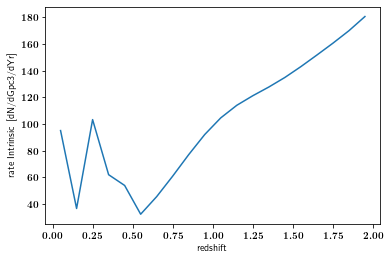

In [51]:
# Plot the intrinsic rate in shell
z         = CI.Shell_centerRedshift
#Now use numpy to just collapse all values
rate      = np.sum(CI.PerSystemPerRedshift_ratesIntrinsic, axis=1)

fig, axes = plt.subplots(1,1)
axes.plot(z, rate)
axes.set_xlabel('redshift')
axes.set_ylabel('rate Intrinsic [dN/dGpc3/dYr]')

## Example mask rate by mass and get observed rate

The columns in the 2D array relate to the individual systems. They are ordered the same
as the systems in the classCOMPAS. Hence we can use the parameters in the classCOMPAS
to create a mask for our result!!! (hence the lazy data :) )

Now a detector looks at all redshift simultaneously so lets sum the rate of each system from every shell in the detector frame. I.e. collapse to array of length number systems

In [52]:
ratePerSystemObserved = np.sum(CI.PerSystemPerRedshift_ratesObserved, axis=0)
print(len(ratePerSystemObserved))

22


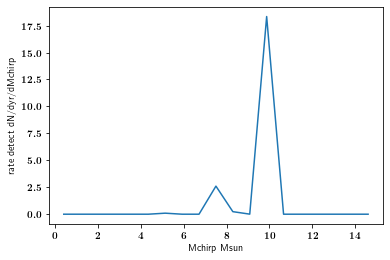

In [53]:
# plot chirp mass distribution

chirpMass  = CI.COMPAS.mChirp
#for every chirpmass I know the rate at which you observe
ratePerSystemObserved = np.sum(CI.PerSystemPerRedshift_ratesObserved, axis=0)

#I only want systems with chirp masses below 10 Msun (for some reason)
mask      = chirpMass < 10


binsMchirp = np.linspace(0,15,20)
dMchirp    = np.diff(binsMchirp)
center     = (binsMchirp[1:]+binsMchirp[:-1])/2.

yvalues, _ = np.histogram(chirpMass[mask], bins=binsMchirp, \
                          weights=ratePerSystemObserved[mask])

dydMchirp  = np.divide(yvalues, dMchirp)

fig, axes = plt.subplots(1,1)
axes.plot(center, dydMchirp)
axes.set_xlabel('Mchirp Msun')
axes.set_ylabel('rate detect dN/dyr/dMchirp')
plt.show()

## 5.3 - Loop over the cosmic Integrator

Once the class is set you could quickly change prescription or DCO
type and recalculate without having to redo the entire instance.
This especially saves time in terms of reading/setting the COMPASdata
and preparing the 2D arrays in the classCosmicIntegrator. The exception being 
if you loop over the data or change the redshift shells. We provide an example in both cases

In [54]:
# loop over prescriptions using the already defined class

#data and redshift shells remain unchanged
SFRprescriptions = ['Madau et al. (2014)',\
                    'Madau et al. (2017)',\
                    'Strolger et al. (2004)',\
                    'Neijssel et al. (2019)']

for SFRprescription in SFRprescriptions:
    #change SFR
    CI.MSSFR.SFRprescription = SFRprescription
    #calculate the result
    CI.cosmologicalIntegration()
    #print the total observed rate
    observedRate = np.round(np.sum(CI.PerSystemPerRedshift_ratesObserved))
    print('Total predicted rate for {} for SFR={} mergers per year'.format(CI.GWdetector_sensitivity, observedRate))

Total predicted rate for O1 for SFR=21.0 mergers per year
Total predicted rate for O1 for SFR=17.0 mergers per year
Total predicted rate for O1 for SFR=31.0 mergers per year
Total predicted rate for O1 for SFR=18.0 mergers per year


In [55]:
# loop over prescriptions using the already defined class

#careful the SFR is still the one of the previous cell!

#loop over DCO types changing the Data 
#This takes longer

types = ['BBH', 'BHNS', 'BNS']

for t in types:
    
    # which DCOs I want
    CI.COMPAS.setCOMPASDCOmask(types=t, pessimistic=True) 
    # Get me the data
    CI.COMPAS.setCOMPASData()
    
    #the number of systems and their delay times have changed 
    #reset arrays results. Note that this goes considerably faster
    #then the first time we do this, because we dont recalculate
    #the redshift table if it is already done :) :) :)
    CI.setBirthTimesAnd2Darrays()
    
    #calculate
    CI.cosmologicalIntegration()

    #print the total observed rate
    observedRate = np.round(np.sum(CI.PerSystemPerRedshift_ratesObserved))
    print('------total predicted rate for {} = {} mergers per year'.format(t, observedRate))

------total predicted rate for BBH = 18.0 mergers per year
------total predicted rate for BHNS = 0.0 mergers per year
------total predicted rate for BNS = 0.0 mergers per year


Note that this means that if you want to loop over 
both DCO types and SFR prescriptions, it is more time-efficient
to loop over types first and then SFR prescriptions.

With this you should be all set. Good luck!
For more info on how to create plots using this pipeline see
the plotting library in the postProcessing notes :)
    
    

# 6. Fast Cosmic Integration

This last section is meant to introduce the "FastCosmicIntegration.py"

This script works in a very similar way as the other cosmic integrators, but it is optimised to be run from the terminal, and thus can be used to easily run on HPC and as part of grid runs. 

For now this only includes one variation of dP/dZ, namely a skewed log-normal distribution for which the default values result in the log-normal distribution from Neijssel et al. 2019.

Following Neijssel et al. 2019, the SFR(z) for this function follows the functional form from Madau & Dickinson 2014, but allows the user to manually adjust the parameters of this function

## 6.1 The magic happens in find_detection_rate()

The most important function in FasCosmicIntegration.py is find_detection_rate
We will spend most of this notebook breaking down this function.


When you run FasCosmicIntegration.py from your terminal, it is run with a lot of default parameters. 
These parameters can be changed from your terminal run. 

E.g. if you would like to know the rate for BHNS in stead of for BBHs (which is default) you would run

 ``` python  FasCosmicIntegration.py --dco_type 'BHNS' ```

In [64]:
# First define the parameters

# For what DCO would you like the rate?  options: ALL, BHBH, BHNS NSNS
dco_type        = "BBH"
weight_column   = None
                        
merges_hubble_time     = True
pessimistic_CEE        = True
no_RLOF_after_CEE      = True

# Options for the redshift evolution 
max_redshift           = 10.0
max_redshift_detection = 2.0
redshift_step          = 0.001
z_first_SF             = 10

# Metallicity of the Universe
min_logZ               = -12.0 
max_logZ               = 0.0 
step_logZ              = 0.01

#and detector sensitivity
sensitivity            = "O1" 
snr_threshold          = 8 

Mc_max                 = 300.0 
Mc_step                = 0.1 
eta_max                = 0.25 
eta_step               = 0.01
snr_max                = 1000.0 
snr_step               = 0.1

# Parameters to calculate the representing SF mass (make sure these match YOUR simulation!)
m1_min          = 15 * u.Msun 
m1_max          = 150 * u.Msun
m2_min          = 0.1 * u.Msun
fbin            = 0.7

# Parameters determining dP/dZ and SFR(z), default options from Neijssel 2019
aSF             = 0.01 
bSF             = 2.77 
cSF             = 2.90 
dSF             = 4.70
#
mu0             = 0.035 
muz             = -0.23 
sigma0          = 0.39
sigmaz          = 0. 
alpha           = 0.0 

## 6.2 You can do all the heavy lifting at once by running find_detection_rate()!


In [65]:
detection_rate, formation_rate, merger_rate, redshifts, COMPAS = FCI.find_detection_rate(
    pathData, dco_type=dco_type, weight_column=weight_column,
    merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
    no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
    max_redshift_detection=max_redshift_detection,
    redshift_step=redshift_step, z_first_SF=z_first_SF,
    m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
    fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
    mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
    min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
    sensitivity=sensitivity, snr_threshold=snr_threshold,
    Mc_max=Mc_max, Mc_step=Mc_step,
    eta_max=eta_max, eta_step=eta_step,
    snr_max=snr_max, snr_step=snr_step)

/home/rwillcox/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  


Average_SF_mass_needed =  4374671.845744508 solMass


In [66]:
print(detection_rate)

[[7.64603393e-11 5.39063172e-10 1.47063179e-09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.04416661e-18 2.85907162e-17 7.82471386e-17 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.82262234e-11 4.10534126e-10 1.11994869e-09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.91162267e-19 2.05982530e-18 5.64303730e-18 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.24730592e-16 5.12385454e-15 1.40267803e-14 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.12113777e-15 2.91000971e-14 7.95643098e-14 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


## 6.3 In the rest of this section, we break this function down piece by piece, to actually understand what is going on :) 

### The function starts by checking the values you have supplied

In [67]:
# assert that input will not produce errors
assert max_redshift_detection <= max_redshift, "Maximum detection redshift cannot be below maximum redshift"
assert m1_min <= m1_max, "Minimum sampled primary mass cannot be above maximum sampled primary mass"
assert np.logical_and(fbin >= 0.0, fbin <= 1.0), "Binary fraction must be between 0 and 1"
assert Mc_step < Mc_max, "Chirp mass step size must be less than maximum chirp mass"
assert eta_step < eta_max, "Symmetric mass ratio step size must be less than maximum symmetric mass ratio"
assert snr_step < snr_max, "SNR step size must be less than maximum SNR"

nonnegative_args = [(max_redshift, "max_redshift"), (max_redshift_detection, "max_redshift_detection"), (m1_min.value, "m1_min"), (m1_max.value, "m1_max"),
                    (m2_min.value, "m2_min"), (mu0, "mu0"), (sigma0, "sigma0"),  
                    (step_logZ, "step_logZ"), (snr_threshold, "snr_threshold"), (Mc_max, "Mc_max"),
                    (Mc_step, "Mc_step"), (eta_max, "eta_max"), (eta_step, "eta_step"), (snr_max, "snr_max"), (snr_step, "snr_step")]


for arg, arg_str in nonnegative_args:
    assert arg >= 0.0, "{} must be nonnegative".format(arg_str)

# warn if input is not advisable
if redshift_step > max_redshift_detection:
    warnings.warn("Redshift step is greater than maximum detection redshift", stacklevel=2)
if Mc_step > 1.0:
    warnings.warn("Chirp mass step is greater than 1.0, large step sizes can produce unpredictable results", stacklevel=2)
if eta_step > 0.1:
    warnings.warn("Symmetric mass ratio step is greater than 0.1, large step sizes can produce unpredictable results", stacklevel=2)
if snr_step > 1.0:
    warnings.warn("SNR step is greater than 1.0, large step sizes can produce unpredictable results", stacklevel=2)

### Use functions in ClassCOMPAS to read your data

In [68]:
# start by getting the necessary data from the COMPAS file
COMPAS = ClassCOMPAS.COMPASData(path, Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
COMPAS.setCOMPASData()
COMPAS.set_sw_weights(weight_column)
COMPAS.find_star_forming_mass_per_binary_sampling()

In [69]:
# COMPAS now contains the data from your hdf5 file:
print('DCO mask', COMPAS.DCOmask)

print('Primary masses {}, \nSecondary masses {}'.format(COMPAS.mass1, COMPAS.mass2))

# Hint, you can see all the options in COMPAS by typing COMPAS. and hitting tab to use tab-complete :)

DCO mask [False False False False False False  True False False  True False False
  True False False  True  True False False False False False False False
  True  True False False False False  True False False False False False
 False False False  True False False False False False  True False False
  True  True False False False False False False False False False False
 False False False False False False False False  True False False  True
 False False False False  True False False False False False False  True
 False False False False False  True False False False False False False
  True False False False False  True  True False False False False False
 False False False  True False False False False False  True]
Primary masses [ 5.63550854 12.08242516  5.35595725  5.34120182  7.03922024  4.27870001
  8.2347584  12.87204315  8.55863967  6.37365538  9.22746379  9.69759326
 17.8253725   7.78862374 34.68904002  8.80203812 12.44144697  8.1897972
  4.75199955 13.65478651 11.85220105  4

### Compute some more useful values

In [70]:
# compute the chirp masses and symmetric mass ratios only for systems of interest
chirp_masses = (COMPAS.mass1*COMPAS.mass2)**(3/5) / (COMPAS.mass1 + COMPAS.mass2)**(1/5)
etas = COMPAS.mass1 * COMPAS.mass2 / (COMPAS.mass1 + COMPAS.mass2)**2
n_binaries = len(chirp_masses)
# another warning on poor input
if max(chirp_masses)*(1+max_redshift_detection) < Mc_max:
    warnings.warn("Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)", stacklevel=2)

/home/rwillcox/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  exec(code_obj, self.user_global_ns, self.user_ns)


## 6.4 Now compute the redshift parameters that you will use for the cosmic integration
mostly a list of redsifts and their corresponding cosmological times

In [71]:
# calculate the redshifts array and its equivalents
redshifts, n_redshifts_detection, times, time_first_SF, distances, shell_volumes = FCI.calculate_redshift_related_params(max_redshift, max_redshift_detection, redshift_step, z_first_SF)

In [72]:
print('redshifts', redshifts, '\ntime_first_SF', time_first_SF, '\nshell_volumes', shell_volumes)

redshifts [0.000e+00 1.000e-03 2.000e-03 ... 9.998e+00 9.999e+00 1.000e+01] 
time_first_SF 479.17426242709416 
shell_volumes [3.38606187e-07 2.36849517e-06 6.42346553e-06 ... 2.60500798e-01
 2.60477182e-01 2.60477182e-01]


### compute the SFR(z)
Following the functional form of Madau & Dickinson (defined by the parameters a,b,c,d), we compute the amount of stellar mass formed at each of the redshifts we supplied

### And convert this to the number of stars that we needed to form
By dividing the ```SFR(z) [Msun/Gpc^-3]``` by the star forming mass needed to get your simulation ```(COMPAS.mass_evolved_per_binary.value * COMPAS.n_systems)```, we basically rescale our simulation to represent the number of stars formed at each redshift.



In [74]:
# find the star forming mass per year per Gpc^3 and convert to total number formed per year per Gpc^3
sfr = FCI.find_sfr(redshifts, a = aSF, b = bSF, c = cSF, d = dSF) # functional form from Madau & Dickinson 2014
n_formed = sfr / (COMPAS.mass_evolved_per_binary.value * COMPAS.n_systems) # Divide the star formation rate density by the representative SF mass

In [75]:
print('sfr', sfr, '[$\mathrm{M_{\odot} yr^{-1} Gpc^{-3}}$]')
print('Star forming mass needed to get your simulation:', (COMPAS.mass_evolved_per_binary.value * COMPAS.n_systems), '[$\mathrm{M_{\odot}$]')
print('Number formation rate', n_formed, '[$\mathrm{yr^{-1} Gpc^{-3}}$]')

sfr [ 9933346.18967071  9960573.30040086  9987846.27805871 ...
 14544878.34395179 14542338.04652796 14539798.41863244] [$\mathrm{M_{\odot} yr^{-1} Gpc^{-3}}$]
Star forming mass needed to get your simulation: 4337229.5201205695 [$\mathrm{M_{\odot}$]
Number formation rate [2.29025145 2.29652898 2.30281709 ... 3.35349519 3.3529095  3.35232395] [$\mathrm{yr^{-1} Gpc^{-3}}$]


## 6.5 Get your metallicity density distribution (dP/dZ) at each redshift

This assumes a skewed-log-normal distribution for metallicities at each redshift. The shape of this distribution is controlled by the parameters:
```mu0, muz, sigma_0, sigma_z, alpha```, which you can set from the terminal flags 

In [77]:
# work out the metallicity distribution at each redshift and probability of drawing each metallicity in COMPAS
dPdlogZ, metallicities, p_draw_metallicity = FCI.find_metallicity_distribution(redshifts, min_logZ_COMPAS = np.log(np.min(COMPAS.initialZ)),
                                                                            max_logZ_COMPAS = np.log(np.max(COMPAS.initialZ)),
                                                                            mu0=mu0, muz=muz, sigma_0=sigma0, sigma_z=sigmaz, alpha = alpha,
                                                                            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ = step_logZ)

In [78]:
print('dPdlogZ={}, \nMetallicities={}, \np_draw_metallicity = {})'.format(dPdlogZ, metallicities, p_draw_metallicity))
# shape dPdlogZ is 
print(np.shape(dPdlogZ))

dPdlogZ=[[1.31120093e-105 2.30288171e-105 4.04192716e-105 ... 2.65386300e-017
  2.12037807e-017 1.69302189e-017]
 [1.35092244e-105 2.37256260e-105 4.16408331e-105 ... 2.62255108e-017
  2.09528758e-017 1.67293007e-017]
 [1.39184472e-105 2.44434739e-105 4.28992338e-105 ... 2.59160382e-017
  2.07049016e-017 1.65307364e-017]
 ...
 [4.80614495e-016 5.95954614e-016 7.38488907e-016 ... 7.36383549e-109
  4.15386923e-109 2.34161790e-109]
 [4.86128746e-016 6.02771213e-016 7.46909823e-016 ... 7.14402232e-109
  4.02973440e-109 2.27156156e-109]
 [4.91705357e-016 6.09664656e-016 7.55425369e-016 ... 6.93075787e-109
  3.90930203e-109 2.20359710e-109]], 
Metallicities=[6.14421235e-06 6.20596271e-06 6.26833368e-06 ... 9.80198673e-01
 9.90049834e-01 1.00000000e+00], 
p_draw_metallicity = 0.3338888029392769)
(10001, 1201)


### Do the actual integration
We are now going to place our DCO systems at each of the chosen redshifts, and check if they have enough time to merge. Together with it's metallicity, the SFR(z) and dP/dZ and the representative star forming mass (n_formed) we can calculate a merger rate!


In [80]:
# calculate the formation and merger rates using what we computed above
formation_rate, merger_rate = FCI.find_formation_and_merger_rates(n_binaries, redshifts, times, time_first_SF, n_formed, dPdlogZ,
                                                                metallicities, p_draw_metallicity, COMPAS.metallicitySystems,
                                                                COMPAS.delayTimes, COMPAS.sw_weights)

### Calculate detection probability

Gravitational wave detectors are not perfect. And since heavy objects make louder gravitational waves, we will see them from farther away. With this function we will compute the probability of detecting each system, which will give us a 'detection_rate'

In [82]:
# create lookup tables for the SNR at 1Mpc as a function of the masses and the probability of detection as a function of SNR
snr_grid_at_1Mpc, detection_probability_from_snr = FCI.compute_snr_and_detection_grids(sensitivity, snr_threshold, Mc_max, Mc_step,
                                                                                eta_max, eta_step, snr_max, snr_step)

# use lookup tables to find the probability of detecting each binary at each redshift
detection_probability = FCI.find_detection_probability(chirp_masses, etas, redshifts, distances, n_redshifts_detection, n_binaries,
                                                    snr_grid_at_1Mpc, detection_probability_from_snr, Mc_step, eta_step, snr_step)

# finally, compute the detection rate using Neijssel+19 Eq. 2
detection_rate = np.zeros(shape=(n_binaries, n_redshifts_detection))
detection_rate = merger_rate[:, :n_redshifts_detection] * detection_probability \
                * shell_volumes[:n_redshifts_detection] / (1 + redshifts[:n_redshifts_detection])

### You are done! :D 

The next step in ```FastCosmicItegration.py``` will append your newly calculated rates to the COMPAS_output.hdf5 file. This happens in ```append_rates()```. Because appending rates could lead to a data heavy file, it might be useful to only append your rates binned by redshit. For this purpose you can set ```append_binned_by_z = True``` in  ```append_rates()```


## 6.6 Now let's go plot your results!

The function ```CI.plot_rates()``` will do the same as what we are going to do in the cells below. 

In [83]:
chirp_masses = (COMPAS.mass1*COMPAS.mass2)**(3./5.) / (COMPAS.mass1 + COMPAS.mass2)**(1./5.)

# sum things up across binaries
total_formation_rate = np.sum(formation_rate, axis=0)
total_merger_rate = np.sum(merger_rate, axis=0)
total_detection_rate = np.sum(detection_rate, axis=0)

# and across redshifts
cumulative_detection_rate = np.cumsum(total_detection_rate)
detection_rate_by_binary = np.sum(detection_rate, axis=1)

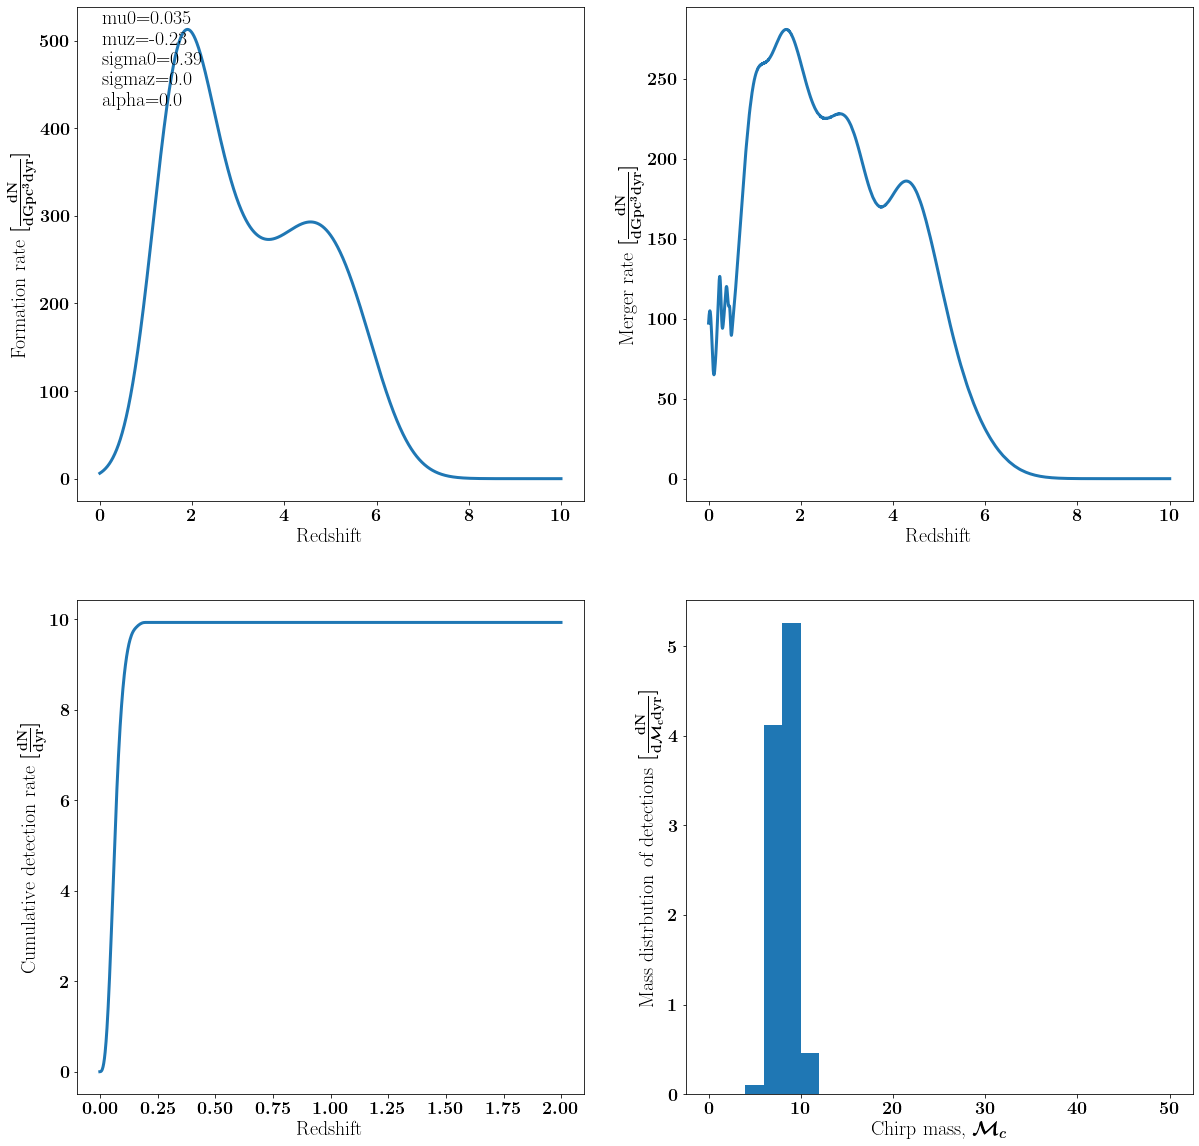

In [84]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

axes[0,0].plot(redshifts, total_formation_rate, lw=lw)
axes[0,0].set_xlabel('Redshift', fontsize=fs)
axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

axes[0,1].plot(redshifts, total_merger_rate, lw=lw)
axes[0,1].set_xlabel('Redshift', fontsize=fs)
axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

axes[1,0].plot(redshifts[:len(cumulative_detection_rate)], cumulative_detection_rate, lw=lw)
axes[1,0].set_xlabel('Redshift', fontsize=fs)
axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

axes[1,1].hist(chirp_masses, weights=detection_rate_by_binary, bins=25, range=(0, 50))
axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

#########################
#Plotvalues

# Add text upper left corner
axes[0,0].text(0.05,0.8, 
        "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
        transform=axes[0,0].transAxes, size = fs) 

for ax in axes.flatten():
    ax.tick_params(labelsize=0.9*fs)

# Save and show :)
plt.savefig(imageDir + "RateInfoHist_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 

### One more plot for the road

Depending on the size of the dataset you used in this notebook, the detected chirp mass distribution may not look great. 

Below is an example plotting the same distribution, but using a KDE to make things look smoother.

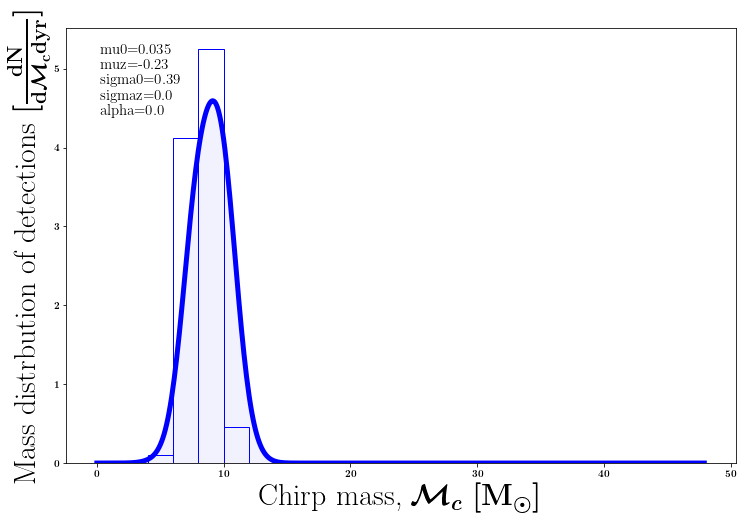

In [85]:
#########################
# Get the Hist    
bins = np.arange(0,50, 2)
hist, bin_edge = np.histogram(chirp_masses, weights = detection_rate_by_binary, bins=bins)
center_bins = (bin_edge[:-1] + bin_edge[1:])/2.
# And the KDE
kernel = stats.gaussian_kde(chirp_masses, bw_method='scott', weights=detection_rate_by_binary)
binwidth = np.diff(bin_edge) 

colors = ['blue']
###########################
#Start plotting
fig, ax = plt.subplots(figsize=(12,8))

########################
# Plot the Hist    
norm = 1.
ax.bar(center_bins, hist/norm, width= np.diff(bins), 
       alpha=1.0, fill=False, edgecolor=colors[0],lw = 1., zorder = 0) 

########################
# Add KDE
x_KDE = np.arange(bins[0],bins[-1],0.1)
KDEy_vals = kernel(x_KDE)*sum(hist)*np.diff(bins)[0]/norm #re-normalize the KDE
ax.plot(x_KDE, KDEy_vals, lw=5, color=colors[0], zorder =1,label = 'KDE of Mchirp')
ax.fill_between(x_KDE, y1=0, y2=KDEy_vals, color=colors[0], alpha = 0.05, zorder = 1)

########################
#Plotvalues
########################
# Add text upper left corner
ax.text(0.05,0.8, 
        "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
        transform=ax.transAxes, size = 15) 

# ax.hist(chirp_masses, weights=detection_rate_by_binary, bins=25, range=(0, 50))
ax.set_xlabel(r'Chirp mass, $\mathcal{M}_c$ $\mathrm{[M_{\odot}]}$', fontsize=30)
ax.set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=30)
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels

# Save and show :)
plt.savefig(imageDir + "RateInfoKDE_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 